# Eyeglass Frame Style Prediction

Simple demo using BGE-Large embeddings via vLLM and KNN classification.

## 1. Setup and Configuration

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import sys
# from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
# load_dotenv()
sys.path.append('../utils/')
from vllm_client import create_vllm_client, get_embeddings

In [2]:
# Configuration - your vLLM details are set via environment variables
# These are automatically configured by the workbench deployment

ENDPOINT = os.getenv('ENDPOINT')
EMBEDDING_MODEL = os.getenv('EMBEDDING_MODEL')
API_KEY = os.getenv('API_KEY')

print(f"Endpoint: {ENDPOINT}")
print(f"Model: {EMBEDDING_MODEL}")
print(f"API Key: {'[CONFIGURED]' if API_KEY else '[MISSING - set in deployment]'}")

Endpoint: https://bge-large-vsp-embedding-demo.apps.cluster-5qlcr.5qlcr.sandbox1342.opentlc.com
Model: bge-large
API Key: [CONFIGURED]


## 2. Load Data

In [4]:
# Load the synthetic electronics data

df = pd.read_csv('../data/synthetic_eyeglass_frames_1k.csv')

df.head(10)

,Frame_Description,Frame_Style
0,limited edition frames (high-end) with premium...,Luxury
1,"contemporary bold rectangular frames, ultra-li...",Modern
2,mixed material frames (bold) with seasonal col...,Fashion
3,wraparound frames (performance-oriented) with ...,Sporty
4,tortoiseshell frames (understated) with handcr...,Classic
5,swimming goggles (adventure-ready) with ventil...,Sporty
6,Designed for vintage-inspired needs: aviator f...,Vintage
7,"contemporary angular frames, flexible hinges.",Modern
8,"nostalgic aviator frames, period-correct sizin...",Vintage
9,Designed for classic revival needs: wayfarer f...,Vintage


## 3. Connect to vLLM and Generate Embeddings

In [5]:
# Create vLLM client
client = create_vllm_client(ENDPOINT, EMBEDDING_MODEL, API_KEY)

In [7]:
# Generate embeddings for part descriptions
descriptions = df['Frame_Description'].tolist()
print(f"🔄 Generating embeddings for {len(descriptions)} descriptions...")

embeddings = get_embeddings(client, descriptions, EMBEDDING_MODEL)

if embeddings:
    X = np.array(embeddings)
    print(f"✅ Generated embeddings with shape: {X.shape}")
    print(f"   - Embedding dimension: {X.shape[1]}")
else:
    print("❌ Failed to generate embeddings")
    print("Check your vLLM endpoint and API key configuration")

🔄 Generating embeddings for 1000 descriptions...
✅ Generated embeddings with shape: (1000, 1024)
   - Embedding dimension: 1024


## 4. Train KNN Classifier

In [8]:
# Prepare labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Frame_Style'])
class_names = label_encoder.classes_

print(f"📊 Dataset info:")
print(f"   - Total samples: {len(X)}")
print(f"   - Number of countries: {len(class_names)}")
print(f"   - Countries: {list(class_names)}")

📊 Dataset info:
   - Total samples: 1000
   - Number of countries: 8
   - Countries: ['Classic', 'Fashion', 'Luxury', 'Modern', 'Professional', 'Sporty', 'Vintage', 'Youthful']


In [9]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Split data: {len(X_train)} train, {len(X_test)} test")


Split data: 800 train, 200 test


In [10]:
# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)
print(f"🤖 Training KNN classifier")
knn.fit(X_train, y_train)
print("✅ KNN training complete")

🤖 Training KNN classifier
✅ KNN training complete


## 5. Evaluate Model

In [11]:
# Make predictions
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"🎯 Model Performance:")
print(f"   - Accuracy: {accuracy:.1%}")

🎯 Model Performance:
   - Accuracy: 98.0%


In [12]:
# Show detailed results
print("\n📊 Detailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


📊 Detailed Classification Report:
              precision    recall  f1-score   support

     Classic       0.96      0.96      0.96        25
     Fashion       1.00      1.00      1.00        24
      Luxury       1.00      1.00      1.00        22
      Modern       0.94      1.00      0.97        29
Professional       0.95      0.86      0.90        22
      Sporty       1.00      1.00      1.00        28
     Vintage       1.00      1.00      1.00        23
    Youthful       1.00      1.00      1.00        27

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



## 6. Visualize Results

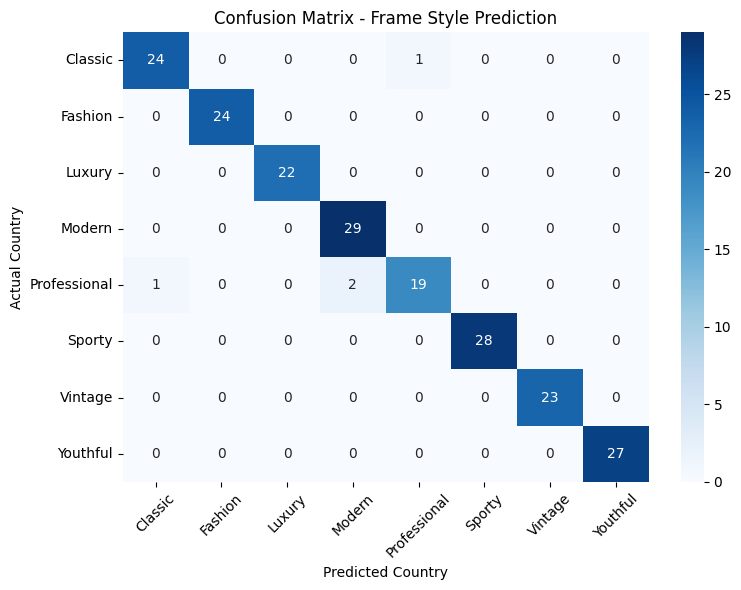

In [14]:
# Create confusion matrix
if len(class_names) > 1:
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Frame Style Prediction')
    plt.xlabel('Predicted Country')
    plt.ylabel('Actual Country')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping confusion matrix (only one class)")

In [15]:
# Show sample predictions
print("\n🔍 Sample Predictions:")
print("=" * 80)

for i in range(min(len(X_test), 5)):
    desc = descriptions[i] if i < len(descriptions) else "Sample description"
    actual = class_names[y_test[i]]
    predicted = class_names[y_pred[i]]
    
    print(f"\nSample {i+1}:")
    print(f"Description: {desc[:100]}{'...' if len(desc) > 100 else ''}")
    print(f"Actual: {actual}")
    print(f"Predicted: {predicted}")
    print(f"Result: {'✅ Correct' if actual == predicted else '❌ Incorrect'}")


🔍 Sample Predictions:

Sample 1:
Description: limited edition frames (high-end) with premium lens options features.
Actual: Youthful
Predicted: Youthful
Result: ✅ Correct

Sample 2:
Description: contemporary bold rectangular frames, ultra-lightweight.
Actual: Modern
Predicted: Modern
Result: ✅ Correct

Sample 3:
Description: mixed material frames (bold) with seasonal collections features.
Actual: Classic
Predicted: Classic
Result: ✅ Correct

Sample 4:
Description: wraparound frames (performance-oriented) with ventilation system features.
Actual: Professional
Predicted: Professional
Result: ✅ Correct

Sample 5:
Description: tortoiseshell frames (understated) with handcrafted details features.
Actual: Vintage
Predicted: Vintage
Result: ✅ Correct


## 7. Test with New Examples

In [27]:
# Test with new part descriptions

unseen_data = pd.read_csv('../data/unseen_eyeglass_frames.csv')

unseen_data.head(10)

,Frame_Description
0,elegant round metal frames with thin wire cons...
1,contemporary geometric frames with ultra-light...
2,retro-inspired cat-eye frames with authentic p...
3,athletic wraparound frames with impact-resista...
4,premium titanium frames with precious metal co...
5,trendy oversized frames with vibrant color opt...
6,business-appropriate rectangular metal frames ...
7,fun bright colored frames with bright color op...
8,timeless oval acetate frames with thin wire co...
9,innovative semi-rimless frames with flexible h...


In [29]:
# Test with new part descriptions

print("🧪 Testing with new examples:")
print("=" * 50)

# Generate embeddings for test descriptions
unseen_descriptions = unseen_data['Frame_Description'].tolist()
test_embeddings = get_embeddings(client, unseen_descriptions, EMBEDDING_MODEL)

if test_embeddings:
    test_X = np.array(test_embeddings)
    test_predictions = knn.predict(test_X)
    test_probabilities = knn.predict_proba(test_X)
    
    for i, desc in enumerate(unseen_descriptions):
        predicted_frame_style = class_names[test_predictions[i]]
        confidence = test_probabilities[i].max()
        
        print(f"\nTest {i+1}: {desc}")
        print(f"Predicted Style: {predicted_frame_style}")
        print(f"Confidence: {confidence:.2f}")
else:
    print("❌ Failed to generate embeddings for test examples")

🧪 Testing with new examples:

Test 1: elegant round metal frames with thin wire construction, adjustable nose pads, gold-plated construction.
Predicted Style: Classic
Confidence: 1.00

Test 2: contemporary geometric frames with ultra-lightweight design, memory metal, minimalist design.
Predicted Style: Modern
Confidence: 1.00

Test 3: retro-inspired cat-eye frames with authentic period details, hand-polished finish, vintage inspired upswept corners.
Predicted Style: Vintage
Confidence: 1.00

Test 4: athletic wraparound frames with impact-resistant construction, UV protection, ventilation system.
Predicted Style: Sporty
Confidence: 1.00

Test 5: premium titanium frames with precious metal construction, hand-engraved details, premium lens options.
Predicted Style: Luxury
Confidence: 1.00

Test 6: trendy oversized frames with vibrant color options, statement piece, large lenses fashion forward.
Predicted Style: Fashion
Confidence: 1.00

Test 7: business-appropriate rectangular metal frame

## Summary

🎉 **Demo Complete!**

This notebook demonstrates:
- ✅ BGE-Large embeddings via vLLM API
- ✅ KNN classification for country prediction
- ✅ Model evaluation and visualization
- ✅ Real-time inference with new examples

The model uses semantic embeddings from transformer models to understand the relationship between frame descriptions and their likely style category.